In [1]:
# train a generative adversarial network on a one-dimensional function
import numpy as np
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import scipy.stats

Using TensorFlow backend.


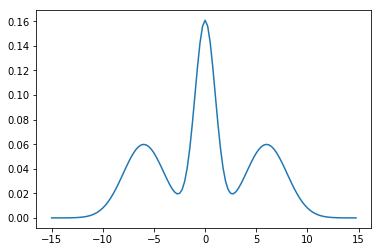

In [2]:
# define function
def f_x(x):
    N1 = scipy.stats.norm(0, 1)
    N2 = scipy.stats.norm(-6, 2)
    N3 = scipy.stats.norm(6, 2)
    
    return 0.4*N1.pdf(x)+0.3*N2.pdf(x)+0.3*N3.pdf(x)

# display the function
x = np.arange(-15,15,0.25)
y = np.array([f_x(i) for i in x])
plt.plot(x,y)
plt.show()

In [3]:
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create the discriminator
discriminator = define_discriminator()

In [4]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# size of the latent space
latent_dim = 10

# create the generator
generator = define_generator(latent_dim)

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# create the gan
gan_model = define_gan(generator, discriminator)

In [6]:
# generate n real samples with class labels
def generate_real_samples(n):
    X1 = np.random.uniform(low=-15, high=15, size=n)
    X2 = np.array([f_x(i) for i in X1])
    X1 = X1.reshape(n,1)
    X2 = X2.reshape(n,1)
    y = np.ones((n,1))
    return np.hstack((X1, X2)), y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [9]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
        
    
    
    if epoch % 3000==0:
        # scatter plot real and fake data points
        plt.scatter(x_real[:, 0], x_real[:, 1], color='red', label = "Real samples at epoch:"+str(epoch))
        plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue', label = "Fake samples at epoch:"+str(epoch))
        plt.legend()
        plt.show()
        
    return [epoch, loss_real, acc_real, loss_fake, acc_fake]

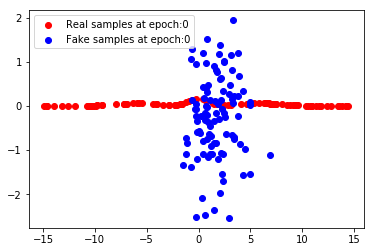

Saving models at: 0
Saving models at: 1000
Saving models at: 2000


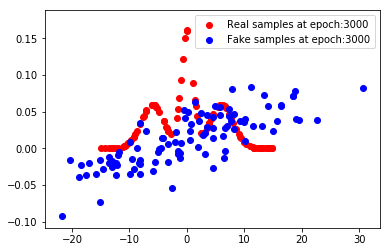

Saving models at: 3000
Saving models at: 4000
Saving models at: 5000


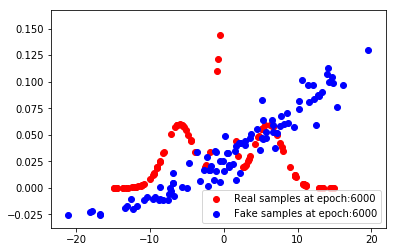

Saving models at: 6000
Saving models at: 7000
Saving models at: 8000


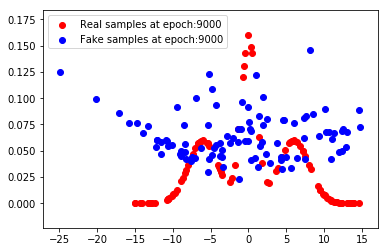

Saving models at: 9000
Saving models at: 10000
Saving models at: 11000


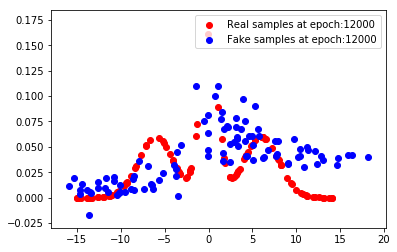

Saving models at: 12000
Saving models at: 13000
Saving models at: 14000


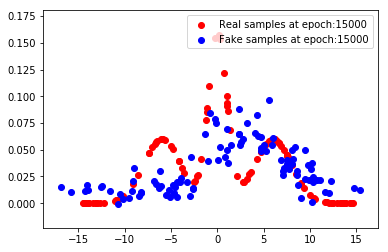

Saving models at: 15000


In [11]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=15001):
    # determine half the size of one batch, for updating the discriminator
    n_batch=128
    n_eval=500
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    
    history = []
    
    for i in range(n_epochs):
    # train discriminator model
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        
        
        # evaluate the model every n_eval epochs
        if i % n_eval == 0:
            history.append(summarize_performance(i, g_model, d_model, latent_dim))
            
        if i% 1000 ==0:
            print("Saving models at:",i)
            
            d_model_json = d_model.to_json()
            with open("d_model.json", "w") as json_file:
                json_file.write(d_model_json)
            d_model.save_weights("d_model.h5")
                        
            g_model_json = g_model.to_json()
            with open("g_model.json", "w") as json_file:
                json_file.write(g_model_json)
            g_model.save_weights("g_model.h5")
            
            gan_model_json = gan_model.to_json()
            with open("gan_model.json", "w") as json_file:
                json_file.write(gan_model_json)
            gan_model.save_weights("model.h5")
        
    return history

# train model
history = train(generator, discriminator, gan_model, latent_dim)

In [11]:
#history = np.array(history)
import pickle
#with open('gan_hist','wb') as f: pickle.dump(history, f)
with open('gan_hist','rb') as f: history = pickle.load(f)

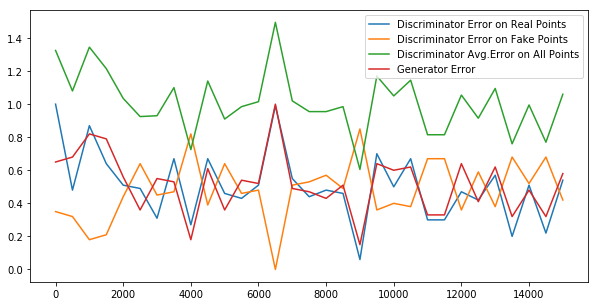

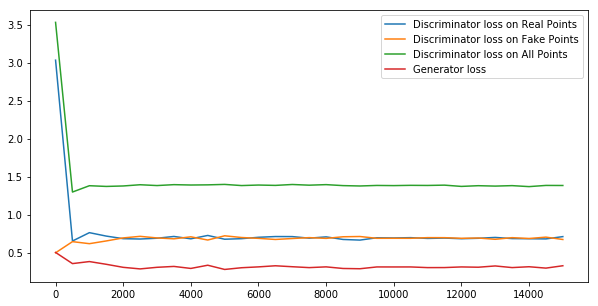

In [12]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(history[:,0],1-history[:,2],label="Discriminator Error on Real Points")
plt.plot(history[:,0],1-history[:,4],label="Discriminator Error on Fake Points")
plt.plot(history[:,0],(2-history[:,2]+history[:,4])/2,label="Discriminator Avg.Error on All Points")
plt.plot(history[:,0],history[:,4],label="Generator Error")
plt.legend()
plt.show()

plt.plot(history[:,0], history[:,1],label="Discriminator loss on Real Points")
plt.plot(history[:,0], history[:,3],label="Discriminator loss on Fake Points")
plt.plot(history[:,0], (history[:,1]+history[:,3]),label="Discriminator loss on All Points")
plt.plot(history[:,0], 1-history[:,3],label="Generator loss")
plt.legend()
plt.show()

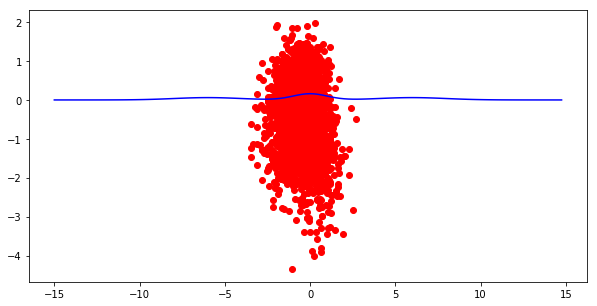

In [13]:
#generating 3000 points from the GAN

x_test, y_test = generate_fake_samples(generator, latent_dim, 3000)
plt.scatter(x_test[:,0],x_test[:,1],color = "red")
plt.plot(x,y,color = "blue")
plt.show()

In [49]:
from sklearn import mixture

g = mixture.GaussianMixture(n_components=3)

ys = x_test[:,1].reshape(3000,1)

g.fit(ys)
print("Means: ",g.means_[0][0],g.means_[1][0],g.means_[2][0])
print("Vaiances: ",g.covariances_[0][0][0],g.covariances_[1][0][0],g.covariances_[2][0][0])
print("Weights: ",g.weights_)

Means:  0.013268209242512274 0.06059665025457816 0.0323811488005321
Vaiances:  6.242081733252168e-05 0.00019527506911832382 0.00010078541993824511
Weights:  [0.53951873 0.25369304 0.20678823]


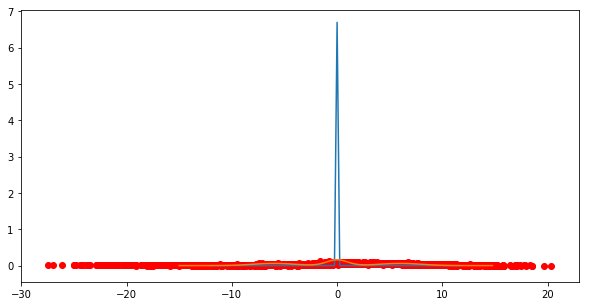

In [54]:
# define function
def f_x2(x):
    N1 = scipy.stats.norm(0.013268209242512274, np.sqrt(6.242081733252168e-05))
    N2 = scipy.stats.norm(0.06059665025457816, np.sqrt(0.00019527506911832382))
    N3 = scipy.stats.norm(0.0323811488005321, np.sqrt(0.00010078541993824511))
    return 0.53951873*N1.pdf(x)+0.25369304*N2.pdf(x)+0.20678823*N3.pdf(x)

# display the function
x2 = np.arange(-12,12,0.25)
y2 = np.array([f_x2(i) for i in x2])
plt.plot(x2,y2)
plt.plot(x,y)
plt.scatter(x_test[:,0],x_test[:,1],color = "red")
plt.show()

In [65]:
from keras.models import model_from_json
# load json and create model
json_file = open('g_model.json', 'r')
loaded_model_json = json_file.read()
js-on_file.close()
ge = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("g_model.h5")
print("Loaded model from disk")

Loaded model from disk


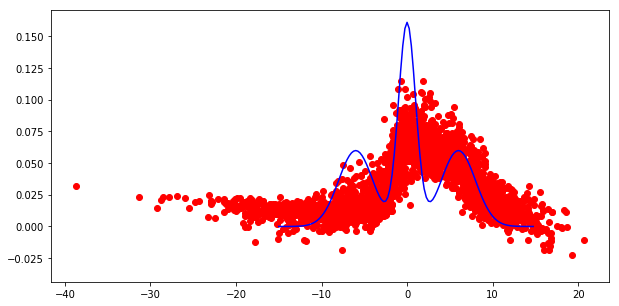

In [66]:
x_test, y_test  = generate_fake_samples(loaded_model, latent_dim, 3000)
plt.scatter(x_test[:,0],x_test[:,1],color = "red")
plt.plot(x,y,color = "blue")
plt.show()